# STOCK MARKET PREDICTION USING NUMERICAL AND TEXTUAL ANALYSIS

In [1]:
import pandas as pd


### NUMERICAL DATA OF TESLA STOCK

In [2]:
stock = pd.read_csv("stock_yfinance_data.csv")
stock = stock[stock['Stock Name'] == "TSLA"]
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


### TEXTUEL DATA OF TESLA STOCK

In [3]:
tweets = pd.read_csv("stock_tweets.csv")
sentiment_data = tweets[tweets['Stock Name'] == "TSLA"]


In [4]:
sentiment = sentiment_data.copy()
sentiment["sent_score"] = ''
sentiment.head()

,Date,Tweet,Stock Name,Company Name,sent_score
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",


In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to C:\Users\PACKARD
[nltk_data]     BELL\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
import unicodedata

### USING SentimentIntensityAnalyzer TO ANALYSE TEXTUEL DATA

In [7]:

for index,row in sentiment.iterrows():
    tweet = unicodedata.normalize("NFKD",row['Tweet'])
    analysis = sia.polarity_scores(tweet)
    sentiment.at[index,'sent_score'] = analysis['compound']
   

In [8]:
sentiment.head()

,Date,Tweet,Stock Name,Company Name,sent_score
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",0.0772
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",0.0
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",0.296
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",-0.7568
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",-0.875


In [9]:
sentiment["Date"] = pd.to_datetime(sentiment['Date'])
sentiment["Date"] = sentiment["Date"].dt.date
sent_set = sentiment[['Date','sent_score']]
sent_set = sent_set.groupby([sent_set["Date"]]).mean()
sent_set.head()

,sent_score
Date,
2021-09-30,0.231552
2021-10-01,0.233704
2021-10-02,0.27194
2021-10-03,0.27157
2021-10-04,0.135388


In [10]:
stock["Date"] = pd.to_datetime(stock["Date"])
stock["Date"] = stock["Date"].dt.date

### FINAL DATASET

In [11]:
df = stock.join(sent_set,how = "left",on="Date")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,sent_score
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA,0.231552
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA,0.233704
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA,0.135388
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA,0.069445
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA,0.19994


In [12]:
import matplotlib.pyplot as plt

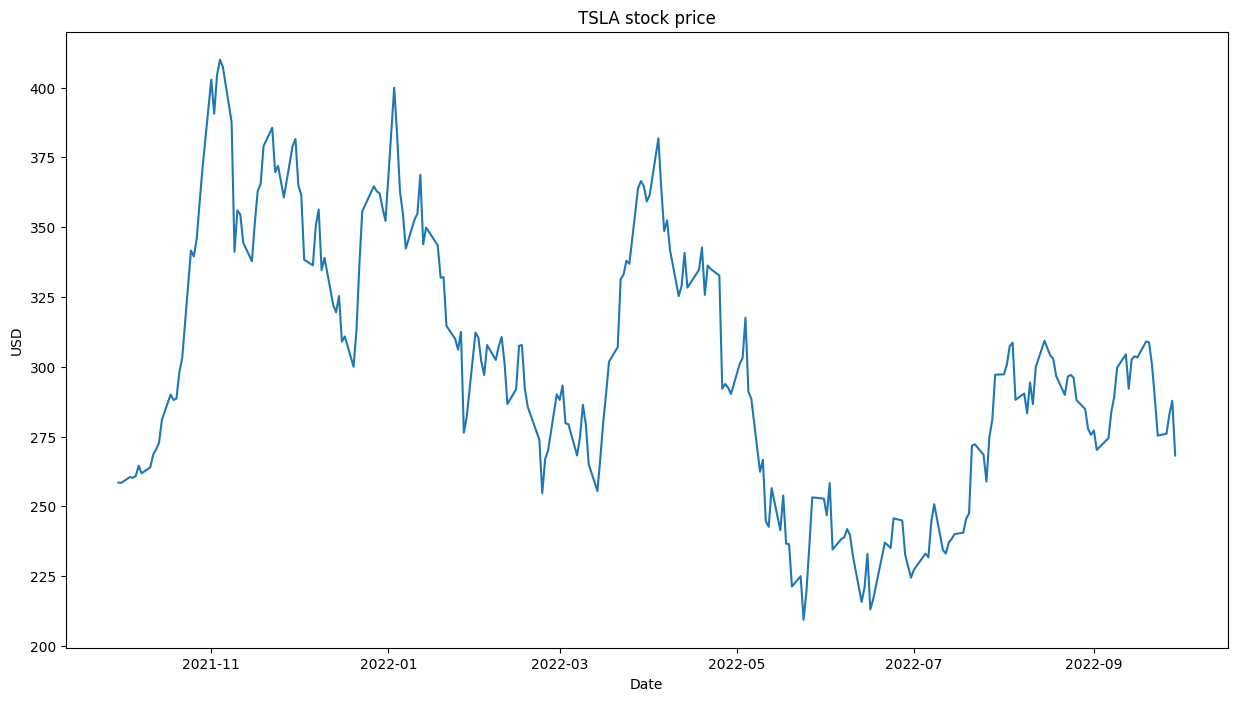

In [13]:
fig,ax = plt.subplots(figsize = (15,8))
ax.plot(df["Date"],df["Close"])
ax.set(xlabel="Date",ylabel="USD",title = "TSLA stock price")
plt.show()

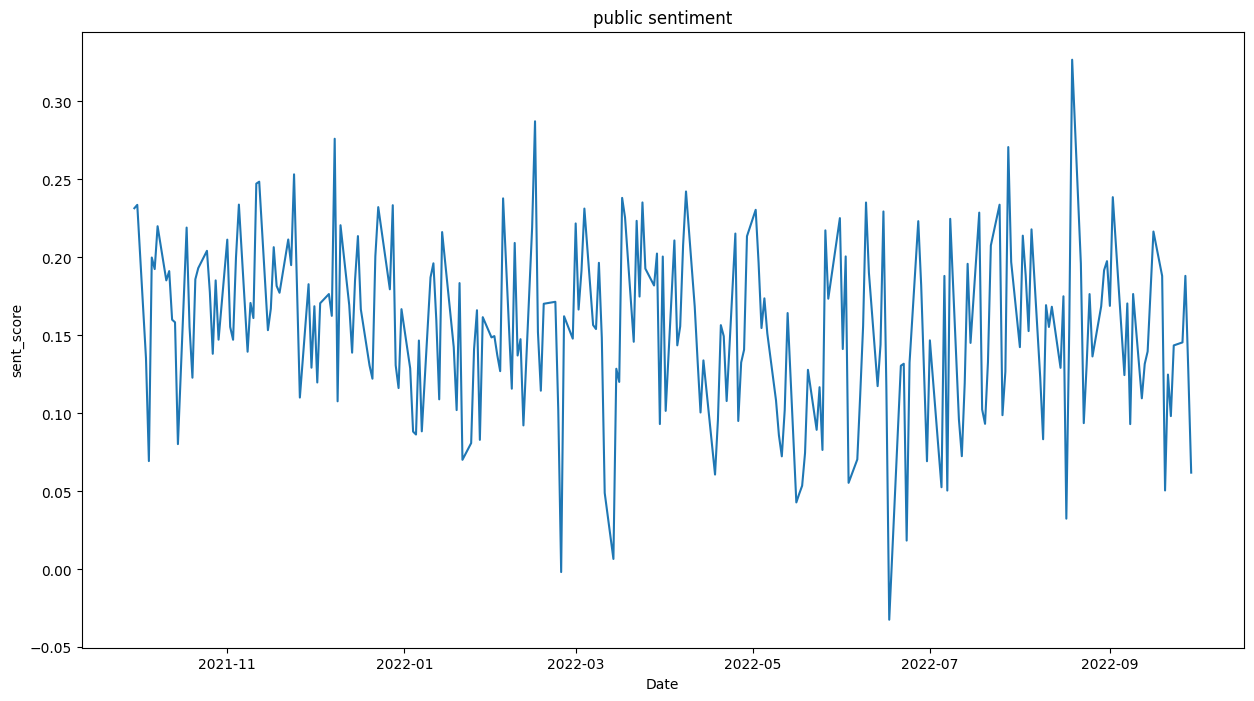

In [14]:
fig,ax = plt.subplots(figsize= (15,8))
ax.plot(df["Date"],df["sent_score"])
ax.set(xlabel = "Date",ylabel = "sent_score",title = "public sentiment")
plt.show()

In [15]:
import statistics

In [16]:
import math

### CREATING THE SAMA MODEL

In [17]:
def SAMA(df, ma_days=5):
    def weight_multiplier(close,sent_score):
        len_close = len(close)
        if len_close<2:
            interval = math.sqrt(close[0])
        else:
            interval = statistics.variance(close)
        max_var = interval
        weighted = 0
        for i in range(len_close):
            if sent_score[i] < 0:
                weighted += close[i] + (2*sent_score[i]*max_var)
            else:
                weighted += close[i] + (sent_score[i]*max_var)
        return weighted/len_close-1
    samas = [df.loc[0,"Close"]]
    rows = df.shape[0]
    for i in range(1,rows):
        if i < ma_days:
            mini_df = df.iloc[:i+1,:]
        elif i+ma_days>=rows:
            mini_df = df.iloc[i:,:]
        else :
            mini_df = df.iloc[i-ma_days+1:i+1,:]
        sama_value = weight_multiplier(mini_df["Close"].tolist(),mini_df["sent_score"].tolist())
        samas.append(sama_value)
    return samas


In [18]:
sama_7 = SAMA(df,ma_days = 7)
df["SAMA_7"] = sama_7
sama_20 = SAMA(df,ma_days = 20)
df["SAMA_20"] = sama_20
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,sent_score,SAMA_7,SAMA_20
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA,0.231552,258.493347,258.493347
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA,0.233704,257.450886,257.450886
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA,0.135388,258.420264,258.420264
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA,0.069445,258.606914,258.606914
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA,0.19994,258.944433,258.944433


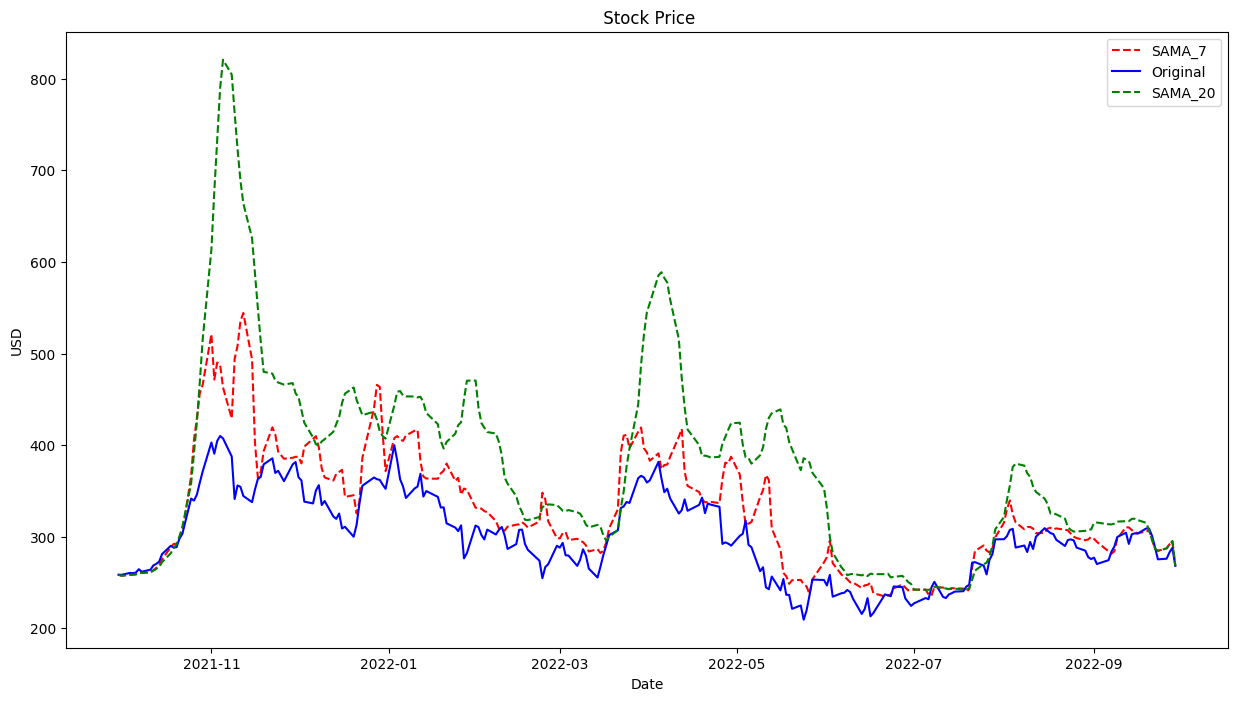

In [19]:
fig,ax = plt.subplots(figsize=(15,8))
ax.plot(df["Date"], df["SAMA_7"], label="SAMA_7", linestyle="--", color="r")
ax.plot(df["Date"], df["Close"], label="Original", color="b")
ax.plot(df["Date"], df["SAMA_20"], label="SAMA_20", linestyle="--", color="g")
ax.set(xlabel="Date",ylabel="USD",title=" Stock Price")

plt.legend()
plt.show()